In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score

from useful_functions import load_transform_split, scatter_resid, scatter_predvreal

In [16]:
X_train,X_test,y_train,y_test,pipeline = load_transform_split(target='DROPOUT_N',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)
print(X_train.shape,X_test.shape)
y_train = y_train.flatten()
y_test = y_test.flatten()
print(y_train.shape,y_test.shape)

(57656, 19) (14414, 19)
(57656,) (14414,)


In [27]:
def preserve_state(func):
    # Decorator to prevent a function from affecting 
    #  the numpy random seed outside of its scope.
    def wrapper(*args,**kwargs):
        state = np.random.get_state() #Store the random state before function call.
        ret = func(*args,**kwargs)    #Call function.
        np.random.set_state(state)    #Revert numpy to random state from before function call.
        return ret
    return wrapper

class simple_progress:
    def __init__(self):
        self.longest = 0
    def update(self,message):
        print(self.longest*" ",end="\r") #Erase previous message.
        print(message,end="\r")          #Print message
        if len(message) > self.longest:  #Update longest message length.
            self.longest = len(message)  
        

def RandomSeedSearchCV(random_model_maker,X_train,y_train,N=50,
                        validation=0.1,cv=5,scoring='neg_mean_squared_error',
                        plot_summary=True,shield_seed=True,verbose=True,
                        random_state=None,**model_maker_kwargs):
    '''
             CAUTION: This function and many of its dependencies are in active development.
    
    Generalized random-search model tuner! Uses random seeds and user-made model-maker to search
    through "acceptable" models and find those that achieve the best cross_validation score.
    
    This function is just a shell to execute the search. It doesn't know anything about the models
    or the parameter space to search through; all of that is encapsulated in the user-provided model-making
    function.
    
    INPUTS:
      random_model_maker   - tl;dr, Function that takes integer and returns model. Returned model must implement
                                     fit and predict methods, like standard sklearn estimators do.
                                     
                             This should be a function defined by the user ahead of time. The function should
                             accept a random seed and then internally construct a model with randomly drawn 
                             hyperparameters. The idea behind this is to take responsibility off of the searcher
                             and put it on the user-provided model-maker. randomseed_searchCV will never know 
                             what type of model you're fitting or what range of which parameters you're sampling.
                             All it will know is that it can give random_model_maker an integer, and it will 
                             return a model that can be fit and used to predict.
                             
      **model_maker_kwargs - Any additional arguments to be passed to the model maker.
                           
      X_train,y_train      - Training data and labels.
      validation           - Fraction to split off for validation testing. Default is 0.1. If None,False,0,or 1
                              are provided, validation testing will not be done.
      cv                   - Integer N for N-fold cross validation.
      scoring              - Metric to use when ranking models.
      plot_summary         - Boolean whether or not to produce a beautiful summary plot!
      shield_seed          - Boolean whether or not to forcibly prevent the model maker from globally changing
                             the numpy random seed.
      verbose              - Boolean whether or not to show progress.
      random_state         - Random state to use for splitting off validation dataset.
    '''
    
    if verbose: progress = simple_progress()
    
    if shield_seed:
        modmkr = preserve_state(random_model_maker)
    else:
        modmkr = random_model_maker
    
    '''
    ## Temp ##
    print("TESTING SHIELD:")
    np.random.seed(42)
    n_dry = np.random.randint(1,10000)
    print("    Dry run: %d"%(n_dry))
    np.random.seed(42)
    modmkr(11)
    n_wet = np.random.randint(1,10000)
    print("    Wet run: %d"%(n_wet))
    if n_dry == n_wet:
        print("  Shields are operative :)")
    else:
        print("  Shields are down!! >:(")
    '''
    
    #Get metric callable from sklearn. L8r I'm gonna make it
    # so the user can provide a callable metric themselves, because I
    # don't like that sklearn uses negative mse instead of positive. It drives me bonkers.
    metric = sklearn.metrics.SCORERS[scoring]
    
    #Split validation set out of the training set, if 
    if validation is None or validation==False or validation>=1 or validation <=0:
        use_val = False
        Xtra,ytra = X_train,y_train
        Xval,yval = None,None
    else:
        use_val = True
        Xtra,Xval,ytra,yval = train_test_split(X_train,y_train,
                                               test_size=validation,
                                               random_state=random_state)
    
    #Draw random seeds to use for model generation.
    seeds = np.random.choice(10*N,N,replace=False)
    
    #Create empty lists to store model performance measures.
    cv_scores = []
    train_metric = []
    valid_metric = []
    times = []
    
    #For each model, find cv_score and metrics. Also store training time.
    for i,seed in enumerate(seeds):
        if verbose: progress.update("%d/%d: Seed = %d"%(i+1,N,seed))
        model = modmkr(seed,**model_maker_kwargs)
        cv_score = np.mean(cross_val_score(model,Xtra,ytra,scoring=scoring,cv=cv))
        cv_scores.append(cv_score)
        
        start_time = time()
        model.fit(Xtra,ytra)
        train_metric.append(-metric(model,Xtra,ytra))
        if use_val: valid_metric.append(-metric(model,Xval,yval))
        times.append(time()-start_time)

    #Plot a summary when done.
    if plot_summary:
        fig,ax = plt.subplots()
        scat = ax.scatter(train_metric,valid_metric,c=times,cmap='coolwarm',s=50)
        cbar = fig.colorbar(scat,ax=ax)
        ax.set_xlabel("Training Metric")
        ax.set_ylabel("Validation Metric")
        cbar.ax.set_ylabel("Training Time")
        mi,ma = 0,np.max([np.max(train_metric),np.max(valid_metric)])
        ax.set_xlim(mi,ma)
        ax.set_ylim(mi,ma)
        ax.plot([mi,ma],[mi,ma],ls='--',color='black')
    
    # L8r....
    # Use stored cv_scores, metrics, and training times to sort the random seeds tested according to which
    #   corresponding models performed the best.

In [28]:
#Here's a random model-maker for RandomForestRegressor. It only needs to be given a seed, and then it goes
# and constructs a model with hyperparameters drawn from internally-defined probability distributions.

def randomseed_rfr_maker(seed,
         ne_lo=40, ne_hi=150,               # (1) n_estimators
         md_lo =3, md_hi =10, md_Pnone=0.5, # (2) max_depth
         mss_lo=2, mss_hi=50,               # (3) min_samples_split
         msl_lo=2, msl_hi=25,               # (4) min_samples_leaf
         mf_lo =3, mf_hi =10, mf_Pnone=0.5, # (5) max_features
         mid_lo=0.,mid_hi=0.2,              # (6) min_impurity_decrease
         n_jobs=4):
    
    #Set random seed.
    np.random.seed(seed)
    
    # Randomly draw parameters and store in kwargs dictionary.
    kwargs = {}
    # (1) Draw n_estimators
    kwargs['n_estimators'] = np.random.randint(ne_lo,ne_hi)
    # (2) Draw max_depth
    if np.random.uniform() < md_Pnone:
        kwargs['max_depth'] = None
    else:
        kwargs['max_depth'] = np.random.randint(md_lo,md_hi)
    # (3) Draw min_samples_split
    kwargs['min_samples_split'] = np.random.randint(mss_lo,mss_hi)
    # (3) Draw min_samples_leaf
    kwargs['min_samples_leaf'] = np.random.randint(msl_lo,msl_hi)
    # (5) Draw max_features
    if np.random.uniform() < mf_Pnone:
        kwargs['max_features'] = None
    else:
        kwargs['max_features'] = np.random.randint(mf_lo,mf_hi)
    # (6) Draw min_impurity_decrease
    kwargs['min_impurity_decrease'] = np.random.uniform(mid_lo,mid_hi)
    #Set n_jobs
    kwargs['n_jobs'] = n_jobs
    
    #Create the model!
    model = RandomForestRegressor(**kwargs)
    
    return model

#Example of a model drawn up from this model-maker.
randomseed_rfr_maker(20)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features=9, max_leaf_nodes=None,
                      min_impurity_decrease=0.13835151635177678,
                      min_impurity_split=None, min_samples_leaf=11,
                      min_samples_split=28, min_weight_fraction_leaf=0.0,
                      n_estimators=139, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

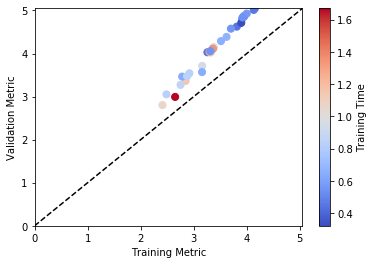

In [29]:
#Searching through RandomForestRegressor models.
RandomSeedSearchCV(randomseed_rfr_maker,X_train,y_train,N=30,shield_seed=True,random_state=42)

In [10]:
print("Test",end="\r")
print("Testing",end="\r")
print("burp")

burp
